In [ ]:
# once deep_tabular_augmentation installation is done, we need to manually update the commom.py file within the deep_tabular_augmentation directory to change "from collections import Iterable"
# to "from from collections.abc import Iterable"
!pip install deep_tabular_augmentation
!pip install mlprep-ls
!pip install 'aif360[all]'
!pip install shap

# Task - 1 (No augmentation)

## 1. Data Analysis and Preprocessing

In [ ]:
# observe descriptive statistics and check for missing data.

import pandas as pd

df = pd.read_csv('/content/dataset_project5.csv')

# Get descriptive statistics
numerical_stats = df.describe()

# Count missing values for every column
missing_values = df.isnull().sum()

# Count total missing values in the entire DataFrame
total_missing = missing_values.sum()


print("Descriptive Statistics:")
print(numerical_stats)
print("\nMissing Values:")
print(missing_values)
print(f"Total Missing Values: {total_missing}")

Descriptive Statistics:
       HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE    LEUCOCYTE  THROMBOCYTE  \
count  3000.000000   3000.000000  3000.000000  3000.000000  3000.000000   
mean     39.249800     13.090467     4.734303     8.121800   256.353333   
std       5.614139      2.004291     0.724817     4.564886   110.472352   
min      14.600000      3.800000     1.930000     1.100000    10.000000   
25%      35.800000     11.900000     4.290000     5.300000   187.000000   
50%      39.500000     13.200000     4.740000     7.100000   257.000000   
75%      43.300000     14.500000     5.200000     9.700000   322.000000   
max      57.000000     18.800000     7.860000    41.100000   830.000000   

               MCH         MCHC          MCV          AGE  
count  3000.000000  3000.000000  3000.000000  3000.000000  
mean     27.774800    33.314867    83.279267    35.061000  
std       2.650355     1.213204     6.544982    15.687617  
min      14.900000    26.000000    54.000000     1.000000  


The piece of code above performs basic descriptive statistics on the data and checks it for missing values.

Descriptive statistics provide valuable information about the central tendency (mean), data spread (standard deviation), and the range of values (minimum and maximum) for each numerical attribute. The output to the code above revealed that the dataset contains a total of 3,000 data points, with no missing values.

The statistics reveal variations in the attributes. For example, 'HAEMOGLOBINS' has a relatively small standard deviation, indicating that data points are closer to the mean, while 'THROMBOCYTE' has a wider range of values.

These statistics are crucial for understanding the dataset's characteristics and distribution, and can be used to test our data augmentation techniques further down the line.

In [ ]:

# drop duplicates.
# normalize the data.

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/content/dataset_project5.csv')

# Remove duplicate rows
columns_to_check = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE', 'SEX', 'SOURCE']
df_no_duplicates = df.drop_duplicates(subset=columns_to_check)


columns_to_normalize = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply the MinMaxScaler to the selected columns in the df without duplicates
df_no_duplicates[columns_to_normalize] = scaler.fit_transform(df_no_duplicates[columns_to_normalize])

# Save the normalized df without duplicates to a new CSV file
df_no_duplicates.to_csv('normalized_data.csv', index=False)


Data normalization is crucial when comparing data points or features across different units or dimensions. It ensures that comparisons are meaningful and valid.

Therefore we have performed data normalization on the dataset provided. Min-max scaling scales data based on the minimum and maximum values. This can help reduce the influence of outliers on the model because extreme values are scaled to be closer to the typical data range.

This code streamlines the data preparation process by removing duplicate rows and applying min-max scaling to specific numerical features.

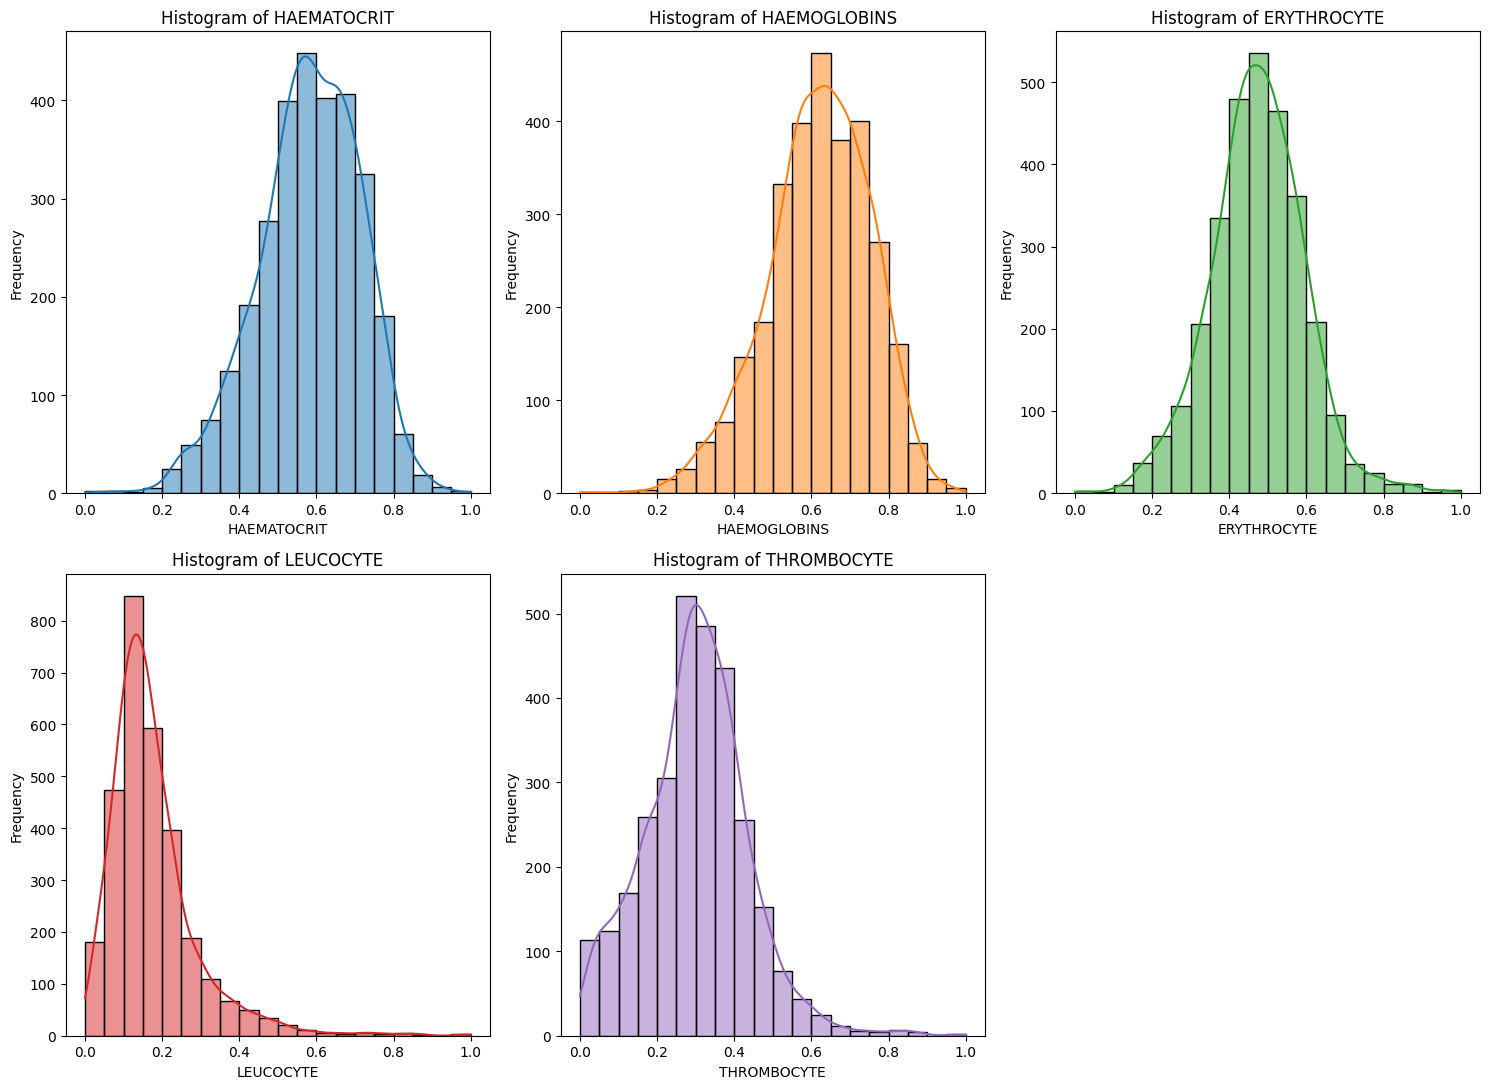

In [ ]:
#visualize the numerical data columns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('normalized_data.csv')

numerical_columns = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE']


numbins = 20

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(15, 11))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    plt.title(f'Histogram of {column}')
    sns.histplot(df[column], bins=numbins, kde=True, color=colors[i-1])
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


This code can be used to compare the distributions of different variables and to later compare the current data with the data produced using the data augmentation technique.

## 2. Model Training


In [ ]:
# Train the XGBoost model.
# perform all the necessary tasks such as grid search, hyperparameter optimization and cross validation.
# Calculate metrics.

In [ ]:
#importing relevant libraries for training.

import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from sklearn.metrics.pairwise import manhattan_distances
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score, StratifiedGroupKFold
from sklearn.pipeline import Pipeline
import warnings
import joblib
from sklearn.model_selection import cross_val_predict, cross_validate
from datetime import datetime
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import train_test_split


In [ ]:
# functions to get results from classification metrics.

def youden_threshold(fpr, tpr, thresholds):

    idx = np.argmax(tpr - fpr)
    return thresholds[idx]


def get_mae(clf, X, y_true):
    # print(clf.best_params_)
    y_pred = clf.predict(X)
    return mean_absolute_error(y_true, y_pred)

def get_auroc(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    auroc = roc_auc_score(y_true, y_pred_score)
    return auroc

def get_auprc(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    pr, re, thresh = precision_recall_curve(y_true, y_pred_score)
    auprc = auc(re, pr)
    return auprc

def get_sens(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]

    sens = tp / (tp + fn)
    return sens

def get_spec(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]

    spec = tn / (tn + fp)
    return spec


def get_ppv(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)

    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]

    ppv = tp / (tp + fp)
    # print(tp,fp,ppv)
    return ppv

def get_npv(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]
    npv = tn / (tn + fn)
    return npv


def get_acc(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]
    acc = (tp + tn) / (tp + fp + fn + tn)
    return acc

def get_metrics_classification( y_true, y_pred_score):
    # y_pred_score = clf.predict_proba(X)[:,1]
    # print(y_pred_score)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    # print(y_pred_class)
    # y_pred_class = y_pred_score
    # Score-based metrics
    auroc = roc_auc_score(y_true, y_pred_score)

    pr, re, thresh = precision_recall_curve(y_true, y_pred_score)
    auprc = auc(re, pr)

    # Class-based metrics
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]

    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    acc = (tp + tn) / (tp + fp + fn + tn)
    # print(ppv)
    # print(tp)
    # print(tp + fp)
    return np.array([auroc, auprc, sens, spec, ppv, npv, acc])

In [ ]:
# XGBoost Training function

import warnings
warnings.filterwarnings("ignore")
def train_model(model_name, type, X_train, y_train,scoring):

    if model_name == 'xgb':

        if type == 'regression':
            kbest = SelectKBest(f_regression)
            model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
            # model = XGBRegressor()

        else:
            kbest = SelectKBest(f_classif)
            model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
            # model = XGBClassifier()

        pipeline = Pipeline([('kbest', kbest), ('xgb', model)])
        param_grid = {
        'xgb__max_depth': [3,4,6,7,8],
        'xgb__n_estimators': [1,5,10,15,20,30,35,40,45,50],
        'xgb__learning_rate': [0.1],#, 0.01,0.02, 0.05],
            # 'kbest__k': [10,15,'all']
            'kbest__k': ['all']
        }


    elif model_name == 'rf':
        if type == 'regression':
            kbest = SelectKBest(f_regression)
            model = RandomForestRegressor(n_jobs=-1, random_state=0)

        else:
            kbest = SelectKBest(f_classif)
            model = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced')
        pipeline = Pipeline([ ('kbest', kbest), ('rf', model)])
        param_grid = {
        'rf__n_estimators': [1,5,10,15,20,30,35,40,45,50],
        'rf__max_features': ['sqrt','log2'],
        'rf__max_depth' : [3,4,6,7,8],
            'kbest__k': [5,10,15,'all']
        }

    elif model_name == 'linear':
        scaler = StandardScaler()
        # X_train = scalar.fit_transform(X_train)
        # X_test = scaler.transform(X_test)
        if type == 'regression':
            kbest = SelectKBest(f_regression)
            model = LinearRegression()
            #
            pipeline = Pipeline([ ('transformer', scaler), ('kbest', kbest), ('li', model)])
            param_grid = {
                'kbest__k': [10,15,'all']
            }
        else:
            kbest = SelectKBest(f_classif)
            model = LogisticRegression(class_weight='balanced', solver = 'liblinear') #('transformer', scalar),
            pipeline = Pipeline([ ('transformer', scaler), ('kbest', kbest), ('li', model)])
            param_grid = {
            # 'li__penalty': ['l1','l2'],
            'li__C': [0.5, 0.8, 1],
                'kbest__k': [10,15,'all']
            }

        # else:
    if type == 'regression':
        # metrics = [get_r2, get_rmse, get_mae]
        metrics = {'get_r2':get_r2, 'get_rmse':get_rmse, 'get_mae':get_mae}

    else:
        # metrics = [get_auroc, get_auprc, get_sens, get_spec, get_ppv, get_npv, get_acc]
        metrics = {'get_auroc': get_auroc, 'get_auprc': get_auprc, 'get_sens': get_sens, 'get_spec': get_spec, 'get_ppv':get_ppv, 'get_npv': get_npv, 'get_acc': get_acc}
    # gkf = GroupKFold(n_splits=5)




    print('--- Initiating grid search ---')


    rf_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, refit = 'get_auroc', scoring = metrics, cv= 5)
    rf_cv.fit(x_train, y_train)
    # print(rf_cv)
    res = {'get_auroc': [], 'get_auprc': [], 'get_sens': [], 'get_spec': [], 'get_ppv':[], 'get_npv': [], 'get_acc': []}
    for i in range(5):
      for metric in res:
        res[metric].append(rf_cv.cv_results_[f'split{i}_test_{metric}'][rf_cv.best_index_])

    for metric in res:
      print(metric[4:], sum(res[metric])/len(res[metric]))



    return rf_cv

In [ ]:
df = pd.read_csv('/content/normalized_data.csv')

In [ ]:
df

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,0.483491,0.533333,0.458685,0.1300,0.365854,0.458515,0.666667,0.425743,0.0,F,out
1,0.681604,0.733333,0.583474,0.2900,0.395122,0.550218,0.701754,0.528713,0.0,F,out
2,0.445755,0.500000,0.473862,0.3025,0.359756,0.388646,0.675439,0.330693,0.0,F,out
3,0.577830,0.660000,0.514334,0.2350,0.434146,0.550218,0.789474,0.485149,0.0,F,out
4,0.384434,0.406667,0.387858,0.5250,0.393902,0.371179,0.526316,0.376238,0.0,M,out
...,...,...,...,...,...,...,...,...,...,...,...
2995,0.761792,0.846667,0.618887,0.1775,0.345122,0.637555,0.807018,0.590099,1.0,M,out
2996,0.740566,0.746667,0.549747,0.1450,0.263415,0.611354,0.578947,0.685149,1.0,M,out
2997,0.497642,0.533333,0.330523,0.2125,0.373171,0.672489,0.622807,0.748515,1.0,M,out
2998,0.634434,0.626667,0.490725,0.2075,0.343902,0.541485,0.508772,0.627723,1.0,M,out


In [ ]:
df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 'M' else 0)
df['SOURCE'] = df['SOURCE'].apply(lambda x: 1 if x == 'out' else 0)

In [ ]:
df

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,0.483491,0.533333,0.458685,0.1300,0.365854,0.458515,0.666667,0.425743,0.0,0,1
1,0.681604,0.733333,0.583474,0.2900,0.395122,0.550218,0.701754,0.528713,0.0,0,1
2,0.445755,0.500000,0.473862,0.3025,0.359756,0.388646,0.675439,0.330693,0.0,0,1
3,0.577830,0.660000,0.514334,0.2350,0.434146,0.550218,0.789474,0.485149,0.0,0,1
4,0.384434,0.406667,0.387858,0.5250,0.393902,0.371179,0.526316,0.376238,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2995,0.761792,0.846667,0.618887,0.1775,0.345122,0.637555,0.807018,0.590099,1.0,1,1
2996,0.740566,0.746667,0.549747,0.1450,0.263415,0.611354,0.578947,0.685149,1.0,1,1
2997,0.497642,0.533333,0.330523,0.2125,0.373171,0.672489,0.622807,0.748515,1.0,1,1
2998,0.634434,0.626667,0.490725,0.2075,0.343902,0.541485,0.508772,0.627723,1.0,1,1


In [ ]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(df[['HAEMATOCRIT','HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'MCH','MCHC',	'MCV'	,'AGE', 'SEX']], df['SOURCE'], test_size = .25)

In [ ]:
# training the model
CV_rfc = train_model('xgb','classification', x_train, y_train, 'roc_auc')

--- Initiating grid search ---
auroc 0.7952107608873897
auprc 0.8382379244523677
sens 0.8384331797235024
spec 0.6439078087375301
ppv 0.7948761152683018
npv 0.7094037244843159
acc 0.764888888888889


In [ ]:
# CV_rfc.best_score_

In [ ]:
# getting best params
CV_rfc.best_params_

{'kbest__k': 'all',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 40}

In [ ]:
# training model on best parameters
bst = XGBClassifier(n_estimators=40, max_depth=3, learning_rate= 0.1)
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# getting the test scores

y_pred = bst.predict(x_test)
res = get_metrics_classification( y_test, y_pred)
print('Test Scores:')
print('auroc: ', res[0])
print('auprc: ', res[1])
print('sens: ', res[2])
print('spec: ', res[3])
print('ppv: ', res[4])
print('npv: ', res[5])
print('acc: ', res[6])

Test Scores:
auroc:  0.7483253588516746
auprc:  0.8803138928402086
sens:  0.9221052631578948
spec:  0.5745454545454546
ppv:  0.7891891891891892
npv:  0.8102564102564103
acc:  0.7946666666666666


## 3. AI fairness

In [ ]:
# Use libraries such as IBM AI fairness to understand if the model is biased towards male or female gender.


In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('/content/dataset_project5.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   3000 non-null   float64
 1   HAEMOGLOBINS  3000 non-null   float64
 2   ERYTHROCYTE   3000 non-null   float64
 3   LEUCOCYTE     3000 non-null   float64
 4   THROMBOCYTE   3000 non-null   int64  
 5   MCH           3000 non-null   float64
 6   MCHC          3000 non-null   float64
 7   MCV           3000 non-null   float64
 8   AGE           3000 non-null   int64  
 9   SEX           3000 non-null   object 
 10  SOURCE        3000 non-null   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 257.9+ KB


In [ ]:
len(df[df['SOURCE']=='in']),len(df[df['SOURCE']=='out'])

(1126, 1874)

In [ ]:
import pandas as pd
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Import your dataset
dataset = pd.read_csv('/content/dataset_project5.csv')

# Encode the 'SEX' column ('M' as 1, 'F' as 0)
dataset.loc[dataset.SEX == 'M', 'SEX'] = 1
dataset.loc[dataset.SEX == 'F', 'SEX'] = 0

# Encode the 'SOURCE' column ('In' as 1, 'Out' as 0)
dataset.loc[dataset.SOURCE == 'in', 'SOURCE'] = 1
dataset.loc[dataset.SOURCE == 'out', 'SOURCE'] = 0

# Create the 'PROTECTED_CLASS' column based on 'SEX'
dataset['PROTECTED_CLASS'] = dataset['SEX'].astype(int)

# Create a StandardDataset for AIF360
privileged_groups = [{'PROTECTED_CLASS': 1}]  # 'M' is considered privileged
unprivileged_groups = [{'PROTECTED_CLASS': 0}]  # 'F' is considered unprivileged
dataset_aif360 = StandardDataset(
    df=dataset,
    label_name='SOURCE',
    favorable_classes=[1],  # 'In' is considered favorable
    protected_attribute_names=['PROTECTED_CLASS'],
    privileged_classes=[[1]],
)

# Calculate and display the initial disparate impact
privileged_metric = BinaryLabelDatasetMetric(
    dataset_aif360,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
initial_disparate_impact = privileged_metric.disparate_impact()
print("Initial Disparate Impact:", initial_disparate_impact)

# If bias is detected, you can use the Disparate Impact Remover mitigation technique
di_remover = DisparateImpactRemover(repair_level=1)
dataset_transf = di_remover.fit_transform(dataset_aif360)

# Calculate and display the new disparate impact after mitigation
new_privileged_metric = BinaryLabelDatasetMetric(
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
new_disparate_impact = new_privileged_metric.disparate_impact()
print("New Disparate Impact after Mitigation:", new_disparate_impact)

# You can use the dataset_transf for any downstream analysis, as the bias has been mitigated.


Initial Disparate Impact: 0.9625327053898484
New Disparate Impact after Mitigation: 0.9625327053898484


## 4. Model Interpretation

In [ ]:
# Use libraries such as SHAP to analyze the dominant features in XGBoost's prediction.
# Do same with LIME.


In [ ]:
import shap

In [ ]:
# best_model['XGBclassifier']

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(x_train.to_numpy())

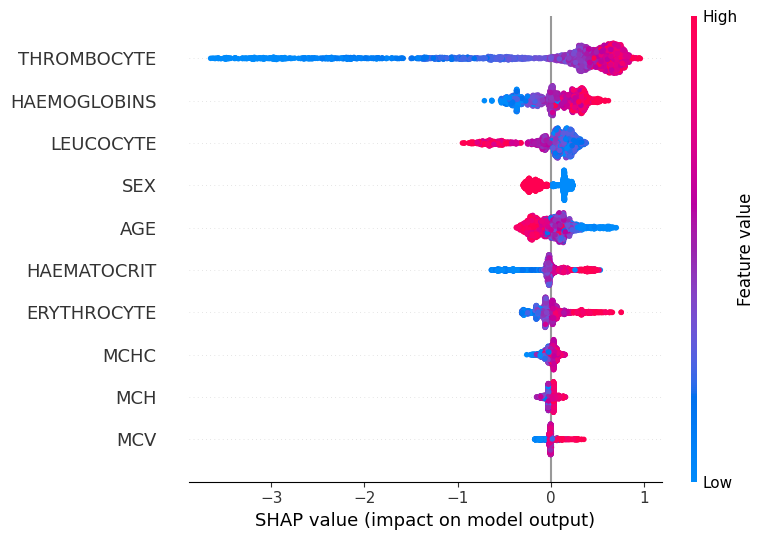

In [ ]:
shap.summary_plot(shap_values, x_train.to_numpy(),feature_names = x_train.columns)

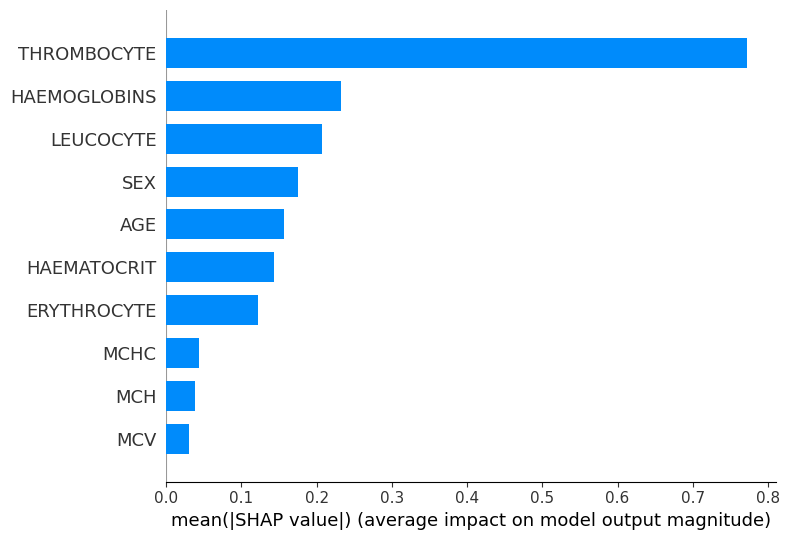

In [ ]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = x_train.columns,show=False)

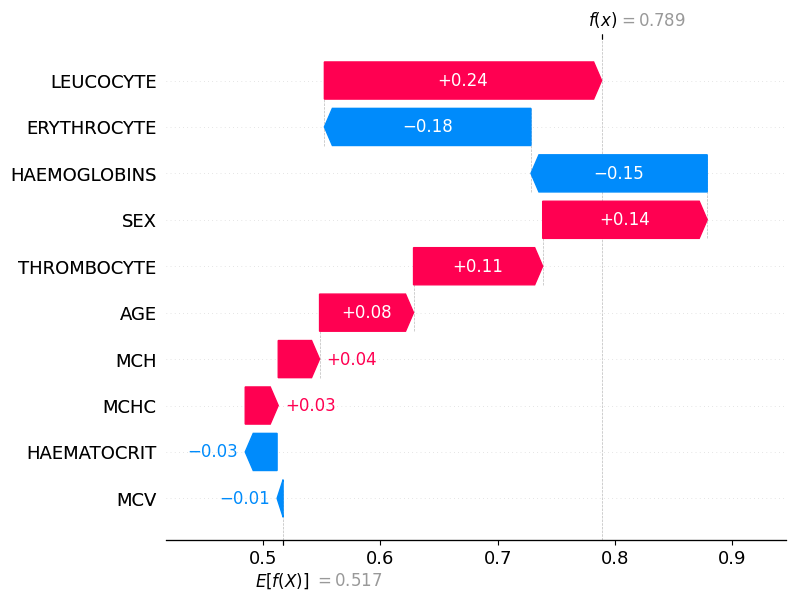

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[5], feature_names = x_train.columns)

# Task - 2 (First augmentation)

## 1. Data Augmentation method 1

In [ ]:
# performing data augmentation using SMOTE.

import pandas as pd
from imblearn.over_sampling import SMOTE

# Load your dataset
data = pd.read_csv("dataset_project5.csv")

# Apply formatting for decimal places
columns_to_format = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'LEUCOCYTE', 'MCH', 'MCHC', 'MCV']
data[columns_to_format] = data[columns_to_format].round(1)  # Round to 1 decimal place
data['ERYTHROCYTE'] = data['ERYTHROCYTE'].round(2)  # Round to 2 decimal places

# Encode 'SEX' column
data['SEX'] = data['SEX'].apply(lambda x: 1 if x == 'M' else 0)

# Separate your features (X) and the target variable (y)
X = data.drop(columns=['SOURCE'])
y = data['SOURCE']

# Apply SMOTE to generate synthetic samples
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame from the resampled data
new_data = pd.concat([X_resampled, y_resampled], axis=1)

# Decode 'SEX' column
data['SEX'] = data['SEX'].apply(lambda x: 'M' if x == 1 else 'F')
new_data['SEX'] = new_data['SEX'].apply(lambda x: 'M' if x == 1 else 'F')

# Append the new data to the existing dataset
augmented_data = pd.concat([data, new_data[:]], ignore_index=True)

# Save the new dataset to a CSV file
augmented_data.to_csv("augmented_dataset.csv", index=False)

In [ ]:
# performing data augmentation using SMOTENC.

import pandas as pd
from imblearn.over_sampling import SMOTENC

# Load your dataset
data = pd.read_csv("dataset_project5.csv")

# Encode 'SEX' column
data['SEX'] = data['SEX'].apply(lambda x: 1 if x == 'M' else 0)

# Specify the index of the categorical feature ('SEX' in this case)
categorical_indices = [9]  # Index 9 corresponds to the 'SEX' column

# Separate your features (X) and the target variable (y)
X = data.drop(columns=['SOURCE'])
y = data['SOURCE']

# Apply SMOTENC to generate synthetic samples
smotenc = SMOTENC(sampling_strategy='auto', categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smotenc.fit_resample(X, y)

# Create a new DataFrame from the resampled data
new_data = pd.concat([X_resampled, y_resampled], axis=1)

# Decode 'SEX' column
data['SEX'] = data['SEX'].apply(lambda x: 'M' if x == 1 else 'F')
new_data['SEX'] = new_data['SEX'].apply(lambda x: 'M' if x == 1 else 'F')

# Append the new data to the existing dataset
augmented_data = pd.concat([data, new_data[:]], ignore_index=True)

# Save the new dataset to a CSV file
# df = pd.concat([data,augmented_data],axis=0)
augmented_data.to_csv("augmented_dataset_nc.csv", index=False)

## 2. Data Analysis and Preprocessing

In [ ]:
# observe descriptive statistics for the augmented data and check for missing data.

import pandas as pd

df = pd.read_csv('augmented_dataset_nc.csv')

# Get descriptive statistics
numerical_stats = df.describe()

# Count missing values for every column
missing_values = df.isnull().sum()

# Count total missing values in the entire DataFrame
total_missing = missing_values.sum()


print("Descriptive Statistics:")
print(numerical_stats)
print("\nMissing Values:")
print(missing_values)
print(f"Total Missing Values: {total_missing}")

Descriptive Statistics:
       HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE    LEUCOCYTE  THROMBOCYTE  \
count  6000.000000   6000.000000  6000.000000  6000.000000  6000.000000   
mean     39.249800     13.090467     4.734303     8.121800   256.353333   
std       5.613671      2.004124     0.724757     4.564506   110.463144   
min      14.600000      3.800000     1.930000     1.100000    10.000000   
25%      35.800000     11.900000     4.290000     5.300000   187.000000   
50%      39.500000     13.200000     4.740000     7.100000   257.000000   
75%      43.300000     14.500000     5.200000     9.700000   322.000000   
max      57.000000     18.800000     7.860000    41.100000   830.000000   

               MCH         MCHC          MCV          AGE  
count  6000.000000  6000.000000  6000.000000  6000.000000  
mean     27.774800    33.314867    83.279267    35.061000  
std       2.650134     1.213102     6.544437    15.686309  
min      14.900000    26.000000    54.000000     1.000000  


In [ ]:
# drop duplicates.
# normalize the augmented data.

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('augmented_dataset_nc.csv')

# Remove duplicate rows
columns_to_check = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE', 'SEX', 'SOURCE']
df_no_duplicates = df.drop_duplicates(subset=columns_to_check)
print(df.drop_duplicates())

columns_to_normalize = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply the MinMaxScaler to the selected columns in the df without duplicates
df_no_duplicates[columns_to_normalize] = scaler.fit_transform(df_no_duplicates[columns_to_normalize])

# Save the normalized df without duplicates to a new CSV file
df_no_duplicates.to_csv('normalized_augmented_data.csv', index=False)


      HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE  \
0       35.100000     11.800000     4.650000   6.300000          310   
1       43.500000     14.800000     5.390000  12.700000          334   
2       33.500000     11.300000     4.740000  13.200000          305   
3       39.100000     13.700000     4.980000  10.500000          366   
4       30.900000      9.900000     4.230000  22.100000          333   
...           ...           ...          ...        ...          ...   
6743    39.827394     13.746576     4.790549   2.353424           61   
6744    26.582533      9.229520     3.208284  15.217160          368   
6745    29.951485     10.042244     3.452673   4.936305          253   
6746    42.200000     14.229806     5.159471   3.282451          185   
6747    37.207340     12.507340     4.535504   3.669716          130   

            MCH       MCHC        MCV  AGE SEX SOURCE  
0     25.400000  33.600000  75.500000    1   F    out  
1     27.500000  34.000


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


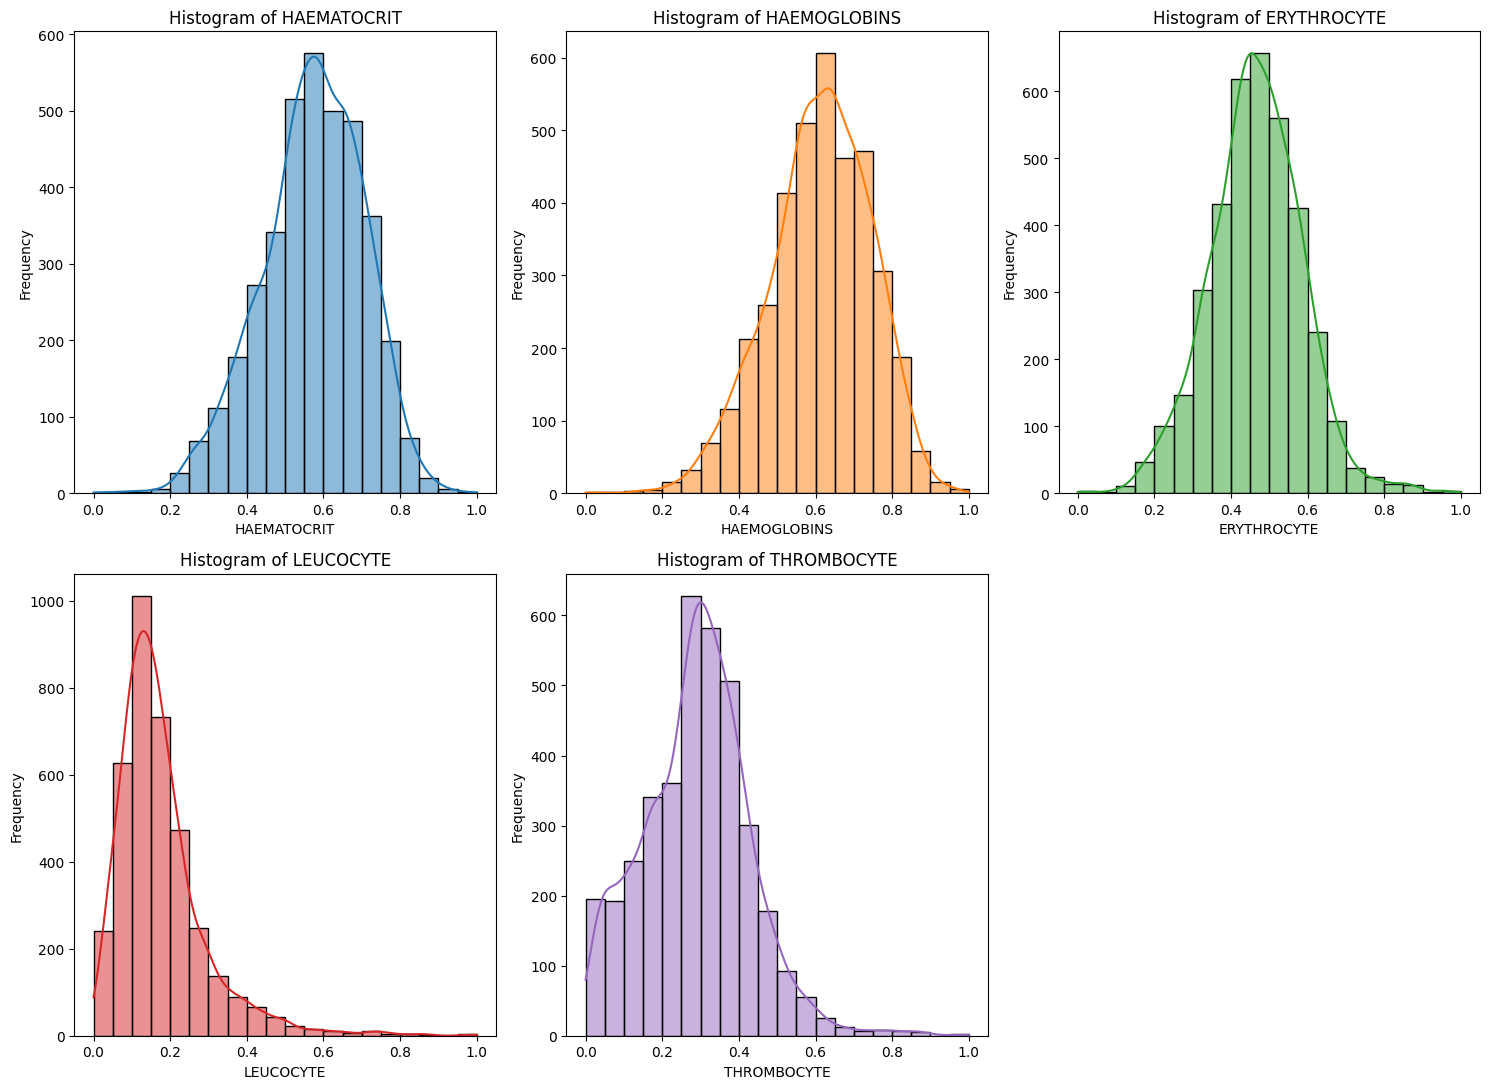

In [ ]:
#visualize the numerical data columns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('normalized_augmented_data.csv')

numerical_columns = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE']

numbins = 20

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(15, 11))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    plt.title(f'Histogram of {column}')
    sns.histplot(df[column], bins=numbins, kde=True, color=colors[i-1])
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## 3. Model Training

In [ ]:
# Train the XGBoost model.
# perform all the necessary tasks such as grid search, hyperparameter optimization and cross validation.
# Calculate metrics.

In [ ]:
#importing relevant libraries for training.

import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from sklearn.metrics.pairwise import manhattan_distances
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score, StratifiedGroupKFold
from sklearn.pipeline import Pipeline
import warnings
import joblib
from sklearn.model_selection import cross_val_predict, cross_validate
from datetime import datetime
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import train_test_split


In [ ]:
# functions to get results from classification metrics.

def youden_threshold(fpr, tpr, thresholds):

    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

def get_mae(clf, X, y_true):
    # print(clf.best_params_)
    y_pred = clf.predict(X)
    return mean_absolute_error(y_true, y_pred)

def get_auroc(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    auroc = roc_auc_score(y_true, y_pred_score)
    return auroc

def get_auprc(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    pr, re, thresh = precision_recall_curve(y_true, y_pred_score)
    auprc = auc(re, pr)
    return auprc

def get_sens(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]

    sens = tp / (tp + fn)
    return sens

def get_spec(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]

    spec = tn / (tn + fp)
    return spec


def get_ppv(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)

    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]

    ppv = tp / (tp + fp)
    # print(tp,fp,ppv)
    return ppv

def get_npv(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]
    npv = tn / (tn + fn)
    return npv


def get_acc(clf, X, y_true):
    # print(clf.best_params_)
    y_pred_score = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]
    acc = (tp + tn) / (tp + fp + fn + tn)
    return acc

def get_metrics_classification( y_true, y_pred_score):
    # y_pred_score = clf.predict_proba(X)[:,1]
    # print(y_pred_score)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    J = youden_threshold(fpr, tpr, thresholds)
    y_pred_class = (y_pred_score >= J).astype('int')
    # print(y_pred_class)
    # y_pred_class = y_pred_score
    # Score-based metrics
    auroc = roc_auc_score(y_true, y_pred_score)

    pr, re, thresh = precision_recall_curve(y_true, y_pred_score)
    auprc = auc(re, pr)

    # Class-based metrics
    cm = confusion_matrix(y_true, y_pred_class)
    # print(cm)
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]

    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    acc = (tp + tn) / (tp + fp + fn + tn)
    # print(ppv)
    # print(tp)
    # print(tp + fp)
    return np.array([auroc, auprc, sens, spec, ppv, npv, acc])

In [ ]:
# XGBoost Training function

import warnings
warnings.filterwarnings("ignore")
def train_model(model_name, type, X_train, y_train,scoring):

    if model_name == 'xgb':

        if type == 'regression':
            kbest = SelectKBest(f_regression)
            model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
            # model = XGBRegressor()

        else:
            kbest = SelectKBest(f_classif)
            model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
            # model = XGBClassifier()

        pipeline = Pipeline([('kbest', kbest), ('xgb', model)])
        param_grid = {
        'xgb__max_depth': [3,4,6,7,8],
        'xgb__n_estimators': [1,5,10,15,20,30,35,40,45,50],
        'xgb__learning_rate': [0.1],#, 0.01,0.02, 0.05],
            # 'kbest__k': [10,15,'all']
            'kbest__k': ['all']
        }


    elif model_name == 'rf':
        if type == 'regression':
            kbest = SelectKBest(f_regression)
            model = RandomForestRegressor(n_jobs=-1, random_state=0)

        else:
            kbest = SelectKBest(f_classif)
            model = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced')
        pipeline = Pipeline([ ('kbest', kbest), ('rf', model)])
        param_grid = {
        'rf__n_estimators': [1,5,10,15,20,30,35,40,45,50],
        'rf__max_features': ['sqrt','log2'],
        'rf__max_depth' : [3,4,6,7,8],
            'kbest__k': [5,10,15,'all']
        }

    elif model_name == 'linear':
        scaler = StandardScaler()
        # X_train = scalar.fit_transform(X_train)
        # X_test = scaler.transform(X_test)
        if type == 'regression':
            kbest = SelectKBest(f_regression)
            model = LinearRegression()
            #
            pipeline = Pipeline([ ('transformer', scaler), ('kbest', kbest), ('li', model)])
            param_grid = {
                'kbest__k': [10,15,'all']
            }
        else:
            kbest = SelectKBest(f_classif)
            model = LogisticRegression(class_weight='balanced', solver = 'liblinear') #('transformer', scalar),
            pipeline = Pipeline([ ('transformer', scaler), ('kbest', kbest), ('li', model)])
            param_grid = {
            # 'li__penalty': ['l1','l2'],
            'li__C': [0.5, 0.8, 1],
                'kbest__k': [10,15,'all']
            }

        # else:
    if type == 'regression':
        # metrics = [get_r2, get_rmse, get_mae]
        metrics = {'get_r2':get_r2, 'get_rmse':get_rmse, 'get_mae':get_mae}

    else:
        # metrics = [get_auroc, get_auprc, get_sens, get_spec, get_ppv, get_npv, get_acc]
        metrics = {'get_auroc': get_auroc, 'get_auprc': get_auprc, 'get_sens': get_sens, 'get_spec': get_spec, 'get_ppv':get_ppv, 'get_npv': get_npv, 'get_acc': get_acc}
    # gkf = GroupKFold(n_splits=5)




    print('--- Initiating grid search ---')

    rf_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, refit = 'get_auroc', scoring = metrics, cv= 5)
    rf_cv.fit(x_train, y_train)
    # print(rf_cv)
    res = {'get_auroc': [], 'get_auprc': [], 'get_sens': [], 'get_spec': [], 'get_ppv':[], 'get_npv': [], 'get_acc': []}
    for i in range(5):
      for metric in res:
        res[metric].append(rf_cv.cv_results_[f'split{i}_test_{metric}'][rf_cv.best_index_])

    for metric in res:
      print(metric[4:], sum(res[metric])/len(res[metric]))



    return rf_cv

In [ ]:
df = pd.read_csv('/content/normalized_augmented_data.csv')

In [ ]:
df

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,0.483491,0.533333,0.458685,0.130000,0.365854,0.458515,0.666667,0.425743,0.000000,F,out
1,0.681604,0.733333,0.583474,0.290000,0.395122,0.550218,0.701754,0.528713,0.000000,F,out
2,0.445755,0.500000,0.473862,0.302500,0.359756,0.388646,0.675439,0.330693,0.000000,F,out
3,0.577830,0.660000,0.514334,0.235000,0.434146,0.550218,0.789474,0.485149,0.000000,F,out
4,0.384434,0.406667,0.387858,0.525000,0.393902,0.371179,0.526316,0.376238,0.000000,M,out
...,...,...,...,...,...,...,...,...,...,...,...
3743,0.594986,0.663105,0.482386,0.031336,0.062195,0.603517,0.747297,0.577892,0.440678,M,in
3744,0.282607,0.361968,0.215562,0.352929,0.436585,0.605698,0.762656,0.571913,0.830508,M,in
3745,0.362063,0.416150,0.256775,0.095908,0.296341,0.619006,0.663772,0.647688,0.898305,F,in
3746,0.650943,0.695320,0.544599,0.054561,0.213415,0.555120,0.677589,0.550010,0.135593,F,in


In [ ]:
df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 'M' else 0)
df['SOURCE'] = df['SOURCE'].apply(lambda x: 1 if x == 'out' else 0)

In [ ]:
#splitting the data

x_train, x_test, y_train, y_test = train_test_split(df[['HAEMATOCRIT','HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'MCH','MCHC',	'MCV'	,'AGE', 'SEX']], df['SOURCE'], test_size = .25)

In [ ]:
# training the model

CV_rfc = train_model('xgb','classification', x_train, y_train, 'roc_auc')

--- Initiating grid search ---
auroc 0.8328734055083578
auprc 0.803883543830274
sens 0.8285714285714286
spec 0.7094654537252838
ppv 0.7416089148714087
npv 0.8083693328490791
acc 0.7687730321169637


In [ ]:
# getting best params
CV_rfc.best_params_

{'kbest__k': 'all',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 7,
 'xgb__n_estimators': 50}

In [ ]:
# training model on best parameters
bst = XGBClassifier(n_estimators=50, max_depth=7, learning_rate= 0.1)
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# getting the test scores
y_pred = bst.predict(x_test)
res = get_metrics_classification( y_test, y_pred)
print('Test Scores:')
print('auroc: ', res[0])
print('auprc: ', res[1])
print('sens: ', res[2])
print('spec: ', res[3])
print('ppv: ', res[4])
print('npv: ', res[5])
print('acc: ', res[6])

Test Scores:
auroc:  0.7828075019821199
auprc:  0.839333412378126
sens:  0.8291139240506329
spec:  0.7365010799136069
ppv:  0.7631067961165049
npv:  0.8080568720379147
acc:  0.7833511205976521


In [ ]:
len(df[df['SOURCE']=='in']),len(df[df['SOURCE']=='out'])

(1874, 1874)

## 4. AI fairness

In [ ]:
# Use libraries such as IBM AI fairness to understand if the model is biased towards male or female gender.
# may include some other type of fairness.

In [ ]:
import pandas as pd
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Import your dataset
dataset = pd.read_csv('/content/normalized_augmented_data.csv')

# Encode the 'SEX' column ('M' as 1, 'F' as 0)
dataset.loc[dataset.SEX == 'M', 'SEX'] = 1
dataset.loc[dataset.SEX == 'F', 'SEX'] = 0

# Encode the 'SOURCE' column ('In' as 1, 'Out' as 0)
dataset.loc[dataset.SOURCE == 'in', 'SOURCE'] = 1
dataset.loc[dataset.SOURCE == 'out', 'SOURCE'] = 0

# Create the 'PROTECTED_CLASS' column based on 'SEX'
dataset['PROTECTED_CLASS'] = dataset['SEX'].astype(int)

# Create a StandardDataset for AIF360
privileged_groups = [{'PROTECTED_CLASS': 1}]  # 'M' is considered privileged
unprivileged_groups = [{'PROTECTED_CLASS': 0}]  # 'F' is considered unprivileged
dataset_aif360 = StandardDataset(
    df=dataset,
    label_name='SOURCE',
    favorable_classes=[1],  # 'In' is considered favorable
    protected_attribute_names=['PROTECTED_CLASS'],
    privileged_classes=[[1]],
)

# Calculate and display the initial disparate impact
privileged_metric = BinaryLabelDatasetMetric(
    dataset_aif360,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
initial_disparate_impact = privileged_metric.disparate_impact()
print("Initial Disparate Impact:", initial_disparate_impact)

# If bias is detected, you can use the Disparate Impact Remover mitigation technique
di_remover = DisparateImpactRemover(repair_level=0.1)
dataset_transf = di_remover.fit_transform(dataset_aif360)

# Calculate and display the new disparate impact after mitigation
new_privileged_metric = BinaryLabelDatasetMetric(
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
new_disparate_impact = new_privileged_metric.disparate_impact()
print("New Disparate Impact after Mitigation:", new_disparate_impact)

# You can use the dataset_transf for any downstream analysis, as the bias has been mitigated.


Initial Disparate Impact: 1.0
New Disparate Impact after Mitigation: 1.0


## 5. Model Interpretation

In [ ]:
# Use libraries such as SHAP to analyze the dominant features in XGBoost's prediction.
# Do same with LIME.

In [ ]:
import shap

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(x_train.to_numpy())

KeyboardInterrupt: ignored

In [ ]:
shap.summary_plot(shap_values, x_train.to_numpy(),feature_names = x_train.columns)

In [ ]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = x_train.columns,show=False)

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[5], feature_names = x_train.columns)

# Task - 3 (Second and Third augmentation)

## 1. Data processing and Data Augmentation

In [ ]:
# uses VAE to generate synthetic data with and without noise

def augment(df,target):
  X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var='SOURCE', test_size=0.3, split_mode='random')

  x_scaler = StandardScaler()

  X_train_scaled = x_scaler.fit_transform(X_train)

  X_test_scaled = x_scaler.transform(X_test)

  X_train_fraud = X_train_scaled[np.where(y_train==target)[0]]
  X_test_fraud = X_test_scaled[np.where(y_test==target)[0]]

  datasets = dta.create_datasets(X_train_fraud, y_train.values[np.where(y_train==target)], X_test_fraud, y_test.values[np.where(y_test==target)])
  data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024, device='cuda'))

  D_in = X_train_fraud.shape[1]
  VAE_arch = [50, 12, 12]
  target_name = 'SOURCE'
  target_class = target
  df_cols = list(df.columns)

  model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to('cuda')
  opt = optim.Adam(model.parameters(), lr=0.01)
  loss_func = dta.customLoss()

  learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

  run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

  run.fit(100, learn)

  sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])


  cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
  model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to('cuda')
  opt = optim.Adam(model.parameters(), lr=0.01)
  learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
  run = dta.Runner(cb_funcs=cbfs)
  run.fit(400, learn)

  df_fake = run.predict_df(learn, no_samples=1000, scaler=x_scaler)
  std_list = list(df[df['SOURCE']==0][df_cols].std()/10)
  df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=1000, mu=0, sigma=std_list, scaler=x_scaler)
  # df_fake_with_noise.head()
  return df_fake, df_fake_with_noise


In [ ]:
df_fake_0, df_fake_with_noise_0 = augment(df, 0)

epoch: 50
train loss is: 5.327569007873535
validation loss is: 1.4877498149871826
epoch: 100
train loss is: 1.7094123363494873
validation loss is: 1.065248966217041
epoch: 150
train loss is: 1.4253404140472412
validation loss is: 1.0651836395263672
epoch: 200
train loss is: 1.3279093503952026
validation loss is: 1.0677268505096436
epoch: 250
train loss is: 1.2789512872695923
validation loss is: 1.0690504312515259
epoch: 300
train loss is: 1.2495061159133911
validation loss is: 1.069838047027588
epoch: 350
train loss is: 1.2298369407653809
validation loss is: 1.0703176259994507
epoch: 400
train loss is: 1.2157561779022217
validation loss is: 1.0706586837768555


In [ ]:
df_fake_1, df_fake_with_noise_1 = augment(df, 1)

epoch: 50
train loss is: 4.13468074798584
validation loss is: 1.0873714685440063
epoch: 100
train loss is: 1.2441308498382568
validation loss is: 0.9171944260597229
epoch: 150
train loss is: 1.0772535800933838
validation loss is: 0.9047187566757202
epoch: 200
train loss is: 1.0205663442611694
validation loss is: 0.9004605412483215
epoch: 250
train loss is: 0.9932506680488586
validation loss is: 0.8983933329582214
epoch: 300
train loss is: 0.9760065078735352
validation loss is: 0.8971193432807922
epoch: 350
train loss is: 0.9644944667816162
validation loss is: 0.8962224721908569
epoch: 400
train loss is: 0.9561789035797119
validation loss is: 0.895548403263092


In [ ]:
X_train.shape

(2100, 10)

## 2. Model Training

In [ ]:
#without noise
df = pd.read_csv('/content/drive/MyDrive/dataset_project5.csv')
df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 'M' else 0)
df['SOURCE'] = df['SOURCE'].apply(lambda x: 1 if x == 'out' else 0)
df_merged = pd.concat([df,df_fake_1, df_fake_0])
df_merged.sample(frac=1)

x_train, x_test, y_train, y_test = train_test_split(df_merged[['HAEMATOCRIT','HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'MCH','MCHC',	'MCV'	,'AGE', 'SEX']], df_merged['SOURCE'], test_size = .25)

In [ ]:
# without noise
# training model on best parameters
CV_rfc = train_model('xgb','classification', x_train, y_train, 'roc_auc')

--- Initiating grid search ---
auroc 0.9294320413885633
auprc 0.9421321127954705
sens 0.9014378145219266
spec 0.806085408564076
ppv 0.8616527653326476
npv 0.8652307060905852
acc 0.8605333333333334


In [ ]:
# getting best params
CV_rfc.best_params_

{'kbest__k': 'all',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 45}

In [ ]:
# without noise
# getting the test scores
bst = XGBClassifier(n_estimators=45, max_depth=4, learning_rate= 0.1)
bst.fit(x_train, y_train)
y_pred = bst.predict(x_test)
res = get_metrics_classification( y_test, y_pred)
print('Test Scores:')
print('auroc: ', res[0])
print('auprc: ', res[1])
print('sens: ', res[2])
print('spec: ', res[3])
print('ppv: ', res[4])
print('npv: ', res[5])
print('acc: ', res[6])

Test Scores:
auroc:  0.8556421373175603
auprc:  0.9143753947699507
sens:  0.931787175989086
spec:  0.7794970986460348
ppv:  0.8569636135508155
npv:  0.8896247240618101
acc:  0.8688


In [ ]:
# with noise
df = pd.read_csv('/content/drive/MyDrive/dataset_project5.csv')
df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 'M' else 0)
df['SOURCE'] = df['SOURCE'].apply(lambda x: 1 if x == 'out' else 0)
df_merged = pd.concat([df,df_fake_with_noise_0, df_fake_with_noise_1])
df_merged.sample(frac=1)

x_train, x_test, y_train, y_test = train_test_split(df_merged[['HAEMATOCRIT','HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'MCH','MCHC',	'MCV'	,'AGE', 'SEX']], df_merged['SOURCE'], test_size = .25)


In [ ]:
# with noise
# training the model
CV_rfc = train_model('xgb','classification', x_train, y_train, 'roc_auc')

--- Initiating grid search ---
auroc 0.931916651006499
auprc 0.9446991307054204
sens 0.9112545189661685
spec 0.8003938087774294
ppv 0.8609848282722009
npv 0.8720084482416229
acc 0.8640000000000001


In [ ]:
# getting best params
CV_rfc.best_params_

{'kbest__k': 'all',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 45}

In [ ]:
# with noise
# training model on best parameters
bst = XGBClassifier(n_estimators=45, max_depth=4, learning_rate= 0.1)
bst.fit(x_train, y_train)

y_pred = bst.predict(x_test)
res = get_metrics_classification( y_test, y_pred)
print('Test Scores:')
print('auroc: ', res[0])
print('auprc: ', res[1])
print('sens: ', res[2])
print('spec: ', res[3])
print('ppv: ', res[4])
print('npv: ', res[5])
print('acc: ', res[6])

Test Scores:
auroc:  0.8405156131956686
auprc:  0.9032869595708124
sens:  0.9196675900277008
spec:  0.7613636363636364
ppv:  0.8405063291139241
npv:  0.8739130434782608
acc:  0.8528


## 4. AI fairness

In [ ]:
# Use libraries such as IBM AI fairness to understand if the model is biased towards male or female gender.
# may include some other type of fairness.

In [ ]:
df_merged['SEX'] = df_merged['SEX'].apply(lambda x: round(x))

In [ ]:
df_merged

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.100000,11.800000,4.650000,6.300000,310.000000,25.400000,33.600000,75.500000,1.000000,0,1
1,43.500000,14.800000,5.390000,12.700000,334.000000,27.500000,34.000000,80.700000,1.000000,0,1
2,33.500000,11.300000,4.740000,13.200000,305.000000,23.800000,33.700000,70.700000,1.000000,0,1
3,39.100000,13.700000,4.980000,10.500000,366.000000,27.500000,35.000000,78.500000,1.000000,0,1
4,30.900000,9.900000,4.230000,22.100000,333.000000,23.400000,32.000000,73.000000,1.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
995,37.431370,12.463284,4.531254,8.447145,210.732391,27.639742,33.267876,82.991020,36.473259,1,0
996,37.429138,12.462743,4.530303,8.435891,210.655319,27.638136,33.267197,82.966179,36.365192,1,0
997,37.432430,12.463507,4.532059,8.455031,210.763550,27.657703,33.266472,83.076622,36.612076,1,0
998,37.434586,12.463912,4.532618,8.463583,210.896347,27.646315,33.267937,83.034615,36.582214,1,0


In [ ]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Import your dataset
dataset = df_merged

# Create the 'PROTECTED_CLASS' column based on 'SEX'
dataset['PROTECTED_CLASS'] = dataset['SEX'].astype(int)

# Create a StandardDataset for AIF360
privileged_groups = [{'PROTECTED_CLASS': 0}]
unprivileged_groups = [{'PROTECTED_CLASS': 1}]
dataset_aif360 = StandardDataset(
    df=dataset,
    label_name='SOURCE',
    favorable_classes=[1],  # 'In' is considered favorable
    protected_attribute_names=['PROTECTED_CLASS'],
    privileged_classes=[[1]],
)

# Calculate and display the initial disparate impact
privileged_metric = BinaryLabelDatasetMetric(
    dataset_aif360,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
initial_disparate_impact = privileged_metric.disparate_impact()
print("Initial Disparate Impact:", initial_disparate_impact)

# If bias is detected, you can use the Disparate Impact Remover mitigation technique
di_remover = DisparateImpactRemover(repair_level=0.1)
dataset_transf = di_remover.fit_transform(dataset_aif360)

# Calculate and display the new disparate impact after mitigation
new_privileged_metric = BinaryLabelDatasetMetric(
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
new_disparate_impact = new_privileged_metric.disparate_impact()
print("New Disparate Impact after Mitigation:", new_disparate_impact)

Initial Disparate Impact: 0.8622409003490278
New Disparate Impact after Mitigation: 0.8622409003490278


## 5. Model Interpretation

In [ ]:
# Use libraries such as SHAP to analyze the dominant features in XGBoost's prediction.
# Do same with LIME.

In [ ]:
import shap

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(x_train.to_numpy())

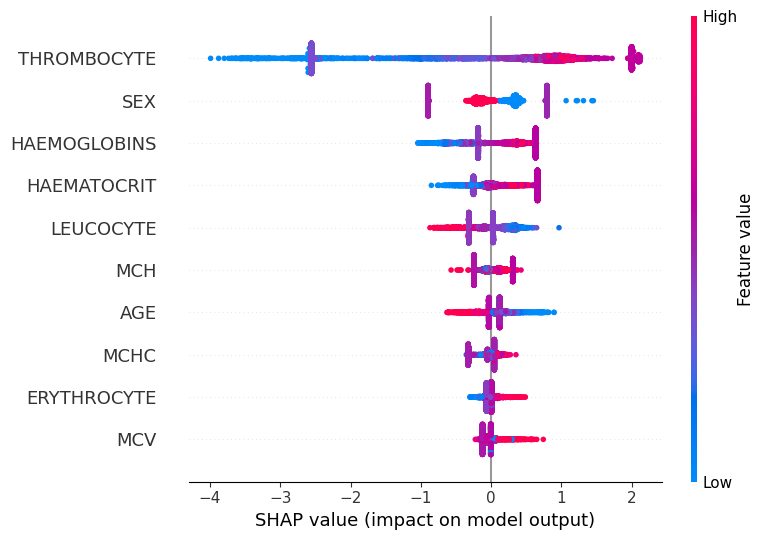

In [ ]:
shap.summary_plot(shap_values, x_train.to_numpy(),feature_names = x_train.columns)

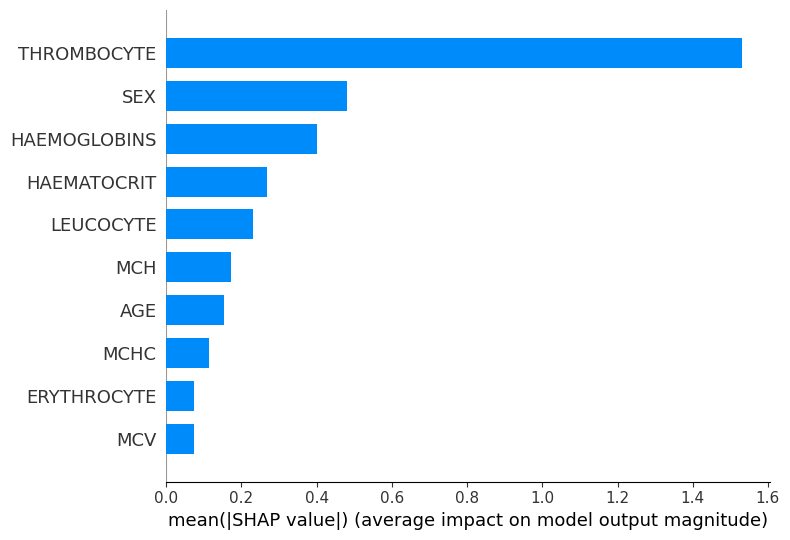

In [ ]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = x_train.columns,show=False)

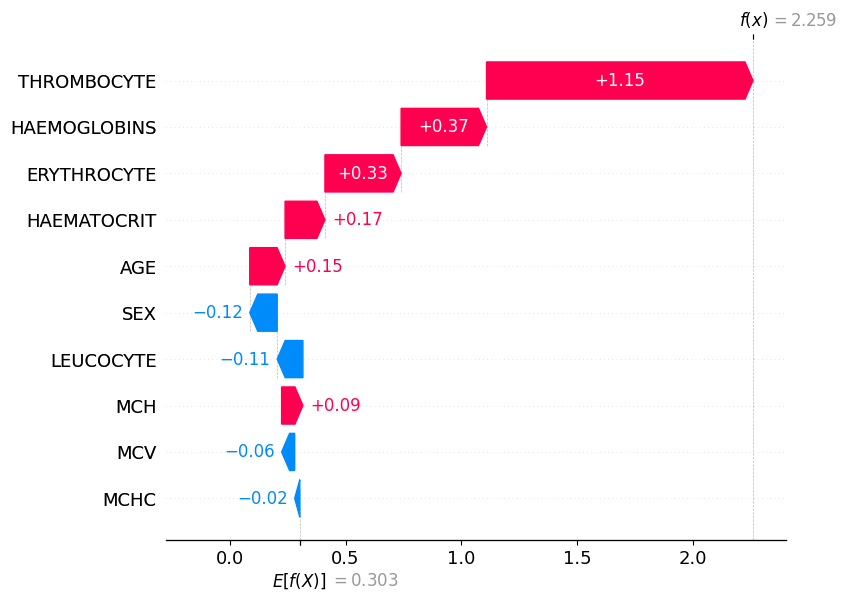

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[5], feature_names = x_train.columns)

# Rough work

In [ ]:
!pip install deep_tabular_augmentation
!pip install mlprep-ls
!pip install 'aif360[all]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 34.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import mlprepare as mlp

In [ ]:
import torch
import deep_tabular_augmentation as dta #/usr/local/lib/python3.10/dist-packages/deep_tabular_augmentation/common.py

In [ ]:
df = pd.read_csv('/content/dataset_project5.csv')

In [ ]:
df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 'M' else 0)
df['SOURCE'] = df['SOURCE'].apply(lambda x: 1 if x == 'out' else 0)

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
df

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,0,1
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,0,1
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,0,1
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,0,1
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2995,46.9,16.5,5.60,8.2,293,29.5,35.2,83.8,60,1,1
2996,46.0,15.0,5.19,6.9,226,28.9,32.6,88.6,60,1,1
2997,35.7,11.8,3.89,9.6,316,30.3,33.1,91.8,60,1,1
2998,41.5,13.2,4.84,9.4,292,27.3,31.8,85.7,60,1,1


In [ ]:
from torch import optim
from functools import partial

In [ ]:
def augment(df,target):
  X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var='SOURCE', test_size=0.3, split_mode='random')

  x_scaler = StandardScaler()

  X_train_scaled = x_scaler.fit_transform(X_train)

  X_test_scaled = x_scaler.transform(X_test)

  X_train_fraud = X_train_scaled[np.where(y_train==target)[0]]
  X_test_fraud = X_test_scaled[np.where(y_test==target)[0]]

  datasets = dta.create_datasets(X_train_fraud, y_train.values[np.where(y_train==target)], X_test_fraud, y_test.values[np.where(y_test==target)])
  data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024, device='cuda'))

  D_in = X_train_fraud.shape[1]
  VAE_arch = [50, 12, 12]
  target_name = 'SOURCE'
  target_class = target
  df_cols = list(df.columns)

  model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to('cuda')
  opt = optim.Adam(model.parameters(), lr=0.01)
  loss_func = dta.customLoss()

  learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

  run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

  run.fit(100, learn)

  sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])


  cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
  model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to('cuda')
  opt = optim.Adam(model.parameters(), lr=0.01)
  learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
  run = dta.Runner(cb_funcs=cbfs)
  run.fit(400, learn)

  df_fake = run.predict_df(learn, no_samples=1000, scaler=x_scaler)
  std_list = list(df[df['SOURCE']==0][df_cols].std()/10)
  df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=1000, mu=0, sigma=std_list, scaler=x_scaler)
  # df_fake_with_noise.head()
  return df_fake, df_fake_with_noise


In [ ]:
df_fake_0, df_fake_with_noise_0 = augment(df, 0)

epoch: 50
train loss is: 5.327569007873535
validation loss is: 1.4877498149871826
epoch: 100
train loss is: 1.7094123363494873
validation loss is: 1.065248966217041
epoch: 150
train loss is: 1.4253404140472412
validation loss is: 1.0651836395263672
epoch: 200
train loss is: 1.3279093503952026
validation loss is: 1.0677268505096436
epoch: 250
train loss is: 1.2789512872695923
validation loss is: 1.0690504312515259
epoch: 300
train loss is: 1.2495061159133911
validation loss is: 1.069838047027588
epoch: 350
train loss is: 1.2298369407653809
validation loss is: 1.0703176259994507
epoch: 400
train loss is: 1.2157561779022217
validation loss is: 1.0706586837768555


In [ ]:
df_fake_1, df_fake_with_noise_1 = augment(df, 1)

epoch: 50
train loss is: 4.13468074798584
validation loss is: 1.0873714685440063
epoch: 100
train loss is: 1.2441308498382568
validation loss is: 0.9171944260597229
epoch: 150
train loss is: 1.0772535800933838
validation loss is: 0.9047187566757202
epoch: 200
train loss is: 1.0205663442611694
validation loss is: 0.9004605412483215
epoch: 250
train loss is: 0.9932506680488586
validation loss is: 0.8983933329582214
epoch: 300
train loss is: 0.9760065078735352
validation loss is: 0.8971193432807922
epoch: 350
train loss is: 0.9644944667816162
validation loss is: 0.8962224721908569
epoch: 400
train loss is: 0.9561789035797119
validation loss is: 0.895548403263092


In [ ]:
X_train.shape

(2100, 10)

In [ ]:
# df_merged = pd.concat([df,df_fake_with_noise_0, df_fake_with_noise_1])
df_merged = pd.concat([df,df_fake_1, df_fake_0])

In [ ]:
df_merged.sample(frac=1)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
2214,26.400000,8.000000,3.100000,10.000000,64.000000,25.800000,30.300000,85.200000,47.000000,1.00000,0
995,46.200000,15.900000,5.370000,6.800000,189.000000,29.600000,34.400000,86.000000,28.000000,1.00000,1
771,49.300000,16.100000,6.270000,5.700000,169.000000,25.700000,32.700000,78.600000,25.000000,1.00000,1
2302,34.900000,11.000000,4.250000,5.600000,333.000000,25.900000,31.500000,82.100000,49.000000,1.00000,1
2577,35.500000,12.100000,4.130000,3.900000,251.000000,29.300000,34.100000,86.000000,54.000000,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...
2130,36.300000,12.100000,4.200000,4.800000,152.000000,28.800000,33.300000,86.400000,46.000000,0.00000,0
1525,44.500000,14.600000,5.800000,6.200000,267.000000,25.200000,32.800000,76.700000,36.000000,1.00000,1
1272,42.800000,14.100000,5.350000,6.800000,302.000000,26.400000,32.900000,80.000000,32.000000,0.00000,1
443,40.268879,13.434685,4.848054,7.933866,284.004974,27.832914,33.313221,83.429184,33.774952,0.50629,1


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_merged[['HAEMATOCRIT','HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'MCH','MCHC',	'MCV'	,'AGE', 'SEX']], df_merged['SOURCE'], test_size = .25)

In [ ]:
# without noise
CV_rfc = train_model('xgb','classification', x_train, y_train, 'roc_auc')

--- Initiating grid search ---
auroc 0.9328375976632042
auprc 0.9456073825648899
sens 0.8861522689257001
spec 0.8285579937304075
ppv 0.8745203035293105
npv 0.8449394206406309
acc 0.8615999999999999


In [ ]:
# with noise
CV_rfc = train_model('xgb','classification', x_train, y_train, 'roc_auc')

--- Initiating grid search ---
auroc 0.9279695225765237
auprc 0.9424886259349275
sens 0.8911005843430437
spec 0.8128388635870744
ppv 0.8668980380869563
npv 0.8500840520648836
acc 0.8578666666666667


In [ ]:
CV_rfc.best_params_

{'kbest__k': 'all',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 50}

In [ ]:
# best_model = CV_rfc.best_estimator_
bst = XGBClassifier(n_estimators=50, max_depth=4, learning_rate= 0.1)
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# y_pred = CV_rfc.predict_proba(X_test)[:, 1]
#without noise
y_pred = bst.predict(x_test)
res = get_metrics_classification( y_test, y_pred)
print('Test Scores:')
print('auroc: ', res[0])
print('auprc: ', res[1])
print('sens: ', res[2])
print('spec: ', res[3])
print('ppv: ', res[4])
print('npv: ', res[5])
print('acc: ', res[6])

Test Scores:
auroc:  0.8451796356921011
auprc:  0.9059210498335152
sens:  0.925207756232687
spec:  0.7651515151515151
ppv:  0.8434343434343434
npv:  0.8820960698689956
acc:  0.8576


In [ ]:
#with noise
y_pred = bst.predict(x_test)
res = get_metrics_classification( y_test, y_pred)
print('Test Scores:')
print('auroc: ', res[0])
print('auprc: ', res[1])
print('sens: ', res[2])
print('spec: ', res[3])
print('ppv: ', res[4])
print('npv: ', res[5])
print('acc: ', res[6])

Test Scores:
auroc:  0.8602305776996632
auprc:  0.91320308385685
sens:  0.9245810055865922
spec:  0.795880149812734
ppv:  0.8586251621271076
npv:  0.8872651356993737
acc:  0.8696


In [ ]:
df_merged['SEX'] = df_merged['SEX'].apply(lambda x: round(x))

In [ ]:
df_merged

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.100000,11.800000,4.650000,6.300000,310.000000,25.400000,33.600000,75.500000,1.000000,0,1
1,43.500000,14.800000,5.390000,12.700000,334.000000,27.500000,34.000000,80.700000,1.000000,0,1
2,33.500000,11.300000,4.740000,13.200000,305.000000,23.800000,33.700000,70.700000,1.000000,0,1
3,39.100000,13.700000,4.980000,10.500000,366.000000,27.500000,35.000000,78.500000,1.000000,0,1
4,30.900000,9.900000,4.230000,22.100000,333.000000,23.400000,32.000000,73.000000,1.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
995,37.431370,12.463284,4.531254,8.447145,210.732391,27.639742,33.267876,82.991020,36.473259,1,0
996,37.429138,12.462743,4.530303,8.435891,210.655319,27.638136,33.267197,82.966179,36.365192,1,0
997,37.432430,12.463507,4.532059,8.455031,210.763550,27.657703,33.266472,83.076622,36.612076,1,0
998,37.434586,12.463912,4.532618,8.463583,210.896347,27.646315,33.267937,83.034615,36.582214,1,0


In [ ]:
import pandas as pd
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Import your dataset
dataset = df_merged

# Encode the 'SEX' column ('M' as 1, 'F' as 0)
dataset.loc[dataset.SEX == 'M', 'SEX'] = 1
dataset.loc[dataset.SEX == 'F', 'SEX'] = 0

# Encode the 'SOURCE' column ('In' as 1, 'Out' as 0)
dataset.loc[dataset.SOURCE == 'in', 'SOURCE'] = 1
dataset.loc[dataset.SOURCE == 'out', 'SOURCE'] = 0

# Create the 'PROTECTED_CLASS' column based on 'SEX'
dataset['PROTECTED_CLASS'] = dataset['SEX'].astype(int)

# Create a StandardDataset for AIF360
privileged_groups = [{'PROTECTED_CLASS': 1}]  # 'M' is considered privileged
unprivileged_groups = [{'PROTECTED_CLASS': 0}]  # 'F' is considered unprivileged
dataset_aif360 = StandardDataset(
    df=dataset,
    label_name='SOURCE',
    favorable_classes=[1],  # 'In' is considered favorable
    protected_attribute_names=['PROTECTED_CLASS'],
    privileged_classes=[[1]],
)

# Calculate and display the initial disparate impact
privileged_metric = BinaryLabelDatasetMetric(
    dataset_aif360,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
initial_disparate_impact = privileged_metric.disparate_impact()
print("Initial Disparate Impact:", initial_disparate_impact)

# If bias is detected, you can use the Disparate Impact Remover mitigation technique
di_remover = DisparateImpactRemover(repair_level=0.1)
dataset_transf = di_remover.fit_transform(dataset_aif360)

# Calculate and display the new disparate impact after mitigation
new_privileged_metric = BinaryLabelDatasetMetric(
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
new_disparate_impact = new_privileged_metric.disparate_impact()
print("New Disparate Impact after Mitigation:", new_disparate_impact)

Initial Disparate Impact: 1.1534408719315596
New Disparate Impact after Mitigation: 1.1534408719315596


In [ ]:
import shap

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(x_train.to_numpy())

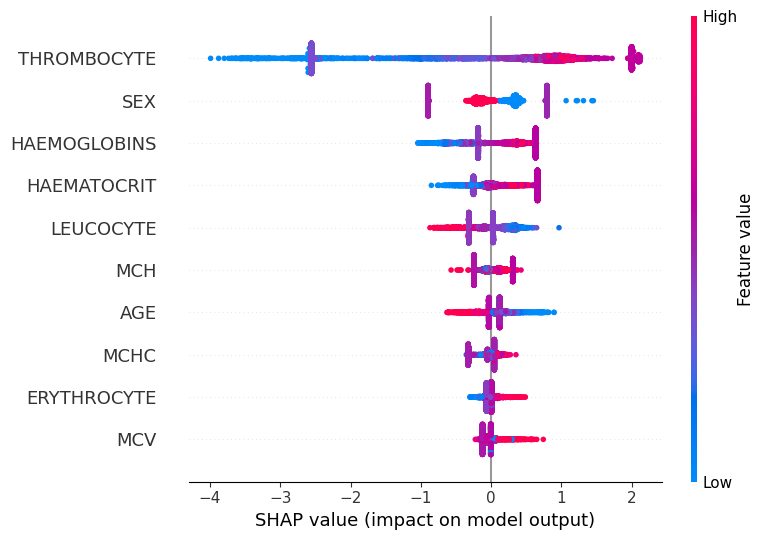

In [ ]:
shap.summary_plot(shap_values, x_train.to_numpy(),feature_names = x_train.columns)

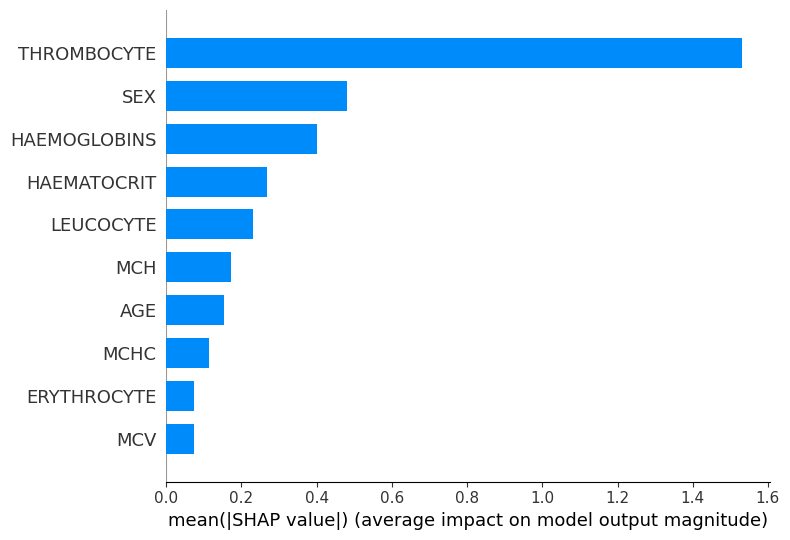

In [ ]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = x_train.columns,show=False)

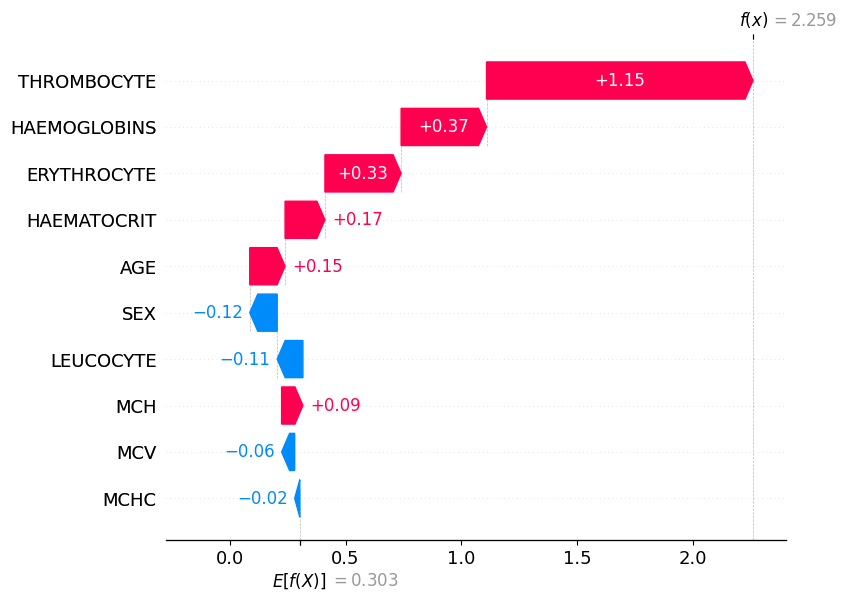

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[5], feature_names = x_train.columns)

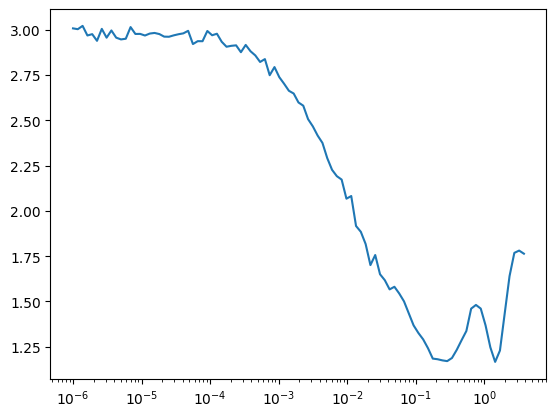

In [ ]:
run.recorder.plot(skip_last=5)

epoch: 50
train loss is: 5.432321071624756
validation loss is: 1.3760168552398682
epoch: 100
train loss is: 1.6921555995941162
validation loss is: 1.0988624095916748
epoch: 150
train loss is: 1.4089432954788208
validation loss is: 1.0627561807632446
epoch: 200
train loss is: 1.3109451532363892
validation loss is: 1.0503305196762085
epoch: 250
train loss is: 1.2616947889328003
validation loss is: 1.0440627336502075
epoch: 300
train loss is: 1.2320780754089355
validation loss is: 1.0403008460998535
epoch: 350
train loss is: 1.212273120880127
validation loss is: 1.0377881526947021
epoch: 400
train loss is: 1.198103666305542
validation loss is: 1.035987377166748


,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,37.877669,11.763848,5.916638,14.411118,302.718365,25.730506,32.265610,77.484132,22.047350,0.594685,0
1,33.805319,9.181673,4.491710,9.302956,315.382014,28.281788,32.814583,67.588428,71.608113,0.321550,0
2,33.871286,12.368609,3.429194,-2.278183,228.413665,27.346201,31.557218,85.975108,24.699305,0.317544,0
3,39.712136,10.590954,5.082454,7.142779,-42.210355,29.161190,34.550140,74.670432,68.158186,0.698747,0
4,40.385541,11.964152,3.979029,11.933760,295.236999,27.105958,34.804375,91.331201,36.131801,0.563694,0


In [ ]:
df_fake_with_noise.to_csv('df_fake_with_noise_0.csv',index = False)

In [ ]:
# df

In [ ]:
df_fake_with_noise.describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0
mean,37.739141,12.627855,4.542726,8.368565,209.413072,27.827803,33.227669,83.232804,36.428730,0.546727,0.0
std,5.803285,1.992395,0.781335,5.608040,125.745988,2.557686,1.280696,6.423955,15.962592,0.489737,0.0
min,15.375707,6.311138,1.816757,-8.613687,-213.212753,18.843457,28.826031,64.326237,-13.679154,-1.108705,0.0
25%,34.037503,11.280939,4.029746,4.634449,122.533910,26.141947,32.337348,78.912573,25.586264,0.213215,0.0
50%,37.772484,12.654308,4.555357,8.549228,213.356437,27.867241,33.264005,83.169017,36.335538,0.558102,0.0
75%,41.536483,13.951375,5.032594,12.234730,295.327438,29.464847,34.060367,87.612415,46.284851,0.880178,0.0
max,57.457483,18.406232,7.395798,23.747377,650.846122,36.446349,36.848727,103.136218,84.524750,1.953732,0.0


In [ ]:
df[df['SOURCE']==0].describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
count,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.0
mean,37.541563,12.514121,4.548943,8.419716,210.713144,27.648046,33.297957,82.942274,36.547957,0.519538,0.0
std,5.854355,2.067833,0.772000,5.499211,123.979792,2.621360,1.257908,6.400749,15.894902,0.499840,0.0
min,16.700000,4.600000,2.150000,1.100000,10.000000,14.900000,26.400000,54.000000,1.000000,0.000000,0.0
25%,33.300000,11.100000,4.030000,4.700000,111.000000,26.500000,32.700000,80.225000,25.000000,0.000000,0.0
50%,38.000000,12.600000,4.570000,7.100000,205.500000,28.200000,33.400000,83.950000,38.000000,1.000000,0.0
75%,41.800000,14.000000,5.030000,10.200000,288.000000,29.400000,34.100000,87.100000,50.000000,1.000000,0.0
max,54.000000,17.900000,7.610000,41.100000,830.000000,33.200000,37.100000,98.100000,60.000000,1.000000,0.0


In [ ]:
std_list_generated = list(df_fake_with_noise[df_fake_with_noise['SOURCE']==1][df_fake_with_noise.columns].std()/10)

In [ ]:
std_list_generated

[0.05238817503324439,
 0.01897255878618901,
 0.006773281169435608,
 0.039552729227325285,
 0.9090497565260494,
 0.026514515060323318,
 0.011197007095399997,
 0.06721115774799825,
 0.14939557002236464,
 0.005061337785706571,
 0.0]

In [ ]:
trainloader.dataset.x.shape, testloader.dataset.x.shape

(torch.Size([2100, 11]), torch.Size([900, 11]))

In [ ]:
df_merged = pd.concat([df,df_fake_with_noise_0, df_fake_with_noise_1])

In [ ]:
df_fake_with_noise_0 = pd.read_csv('df_fake_with_noise_0.csv')
df_fake_with_noise_1 = pd.read_csv('df_fake_with_noise_1.csv')

In [ ]:
len(df_merged[df_merged['SOURCE']==0])

2126

In [ ]:
df_merged.sample(frac=1)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
1192,37.800000,13.000000,4.880000,14.200000,325.000000,26.600000,34.400000,77.500000,31.000000,0.000000,1
419,34.955219,11.307184,6.209365,-1.650396,91.028635,25.607950,33.792173,83.169365,33.717160,-0.705896,0
33,42.331349,10.434886,5.130039,14.369216,-19.045737,26.575475,32.202920,73.230625,28.278144,0.336007,0
1730,38.200000,12.600000,4.450000,14.400000,221.000000,28.300000,33.000000,85.800000,40.000000,0.000000,1
356,44.431569,14.983157,4.515557,-3.289724,109.470001,26.451709,32.866812,84.476028,43.453665,0.117214,0
...,...,...,...,...,...,...,...,...,...,...,...
400,43.700000,15.300000,5.430000,12.800000,307.000000,28.200000,35.000000,80.500000,17.000000,1.000000,1
173,43.200000,15.600000,6.220000,9.400000,100.000000,25.100000,36.100000,69.500000,7.000000,1.000000,0
2118,45.800000,16.000000,5.600000,6.900000,250.000000,28.600000,34.900000,81.800000,46.000000,1.000000,0
118,39.370633,8.864371,5.159390,12.719737,276.829980,26.927799,34.683008,77.494330,28.962231,0.579185,1


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_merged[['HAEMATOCRIT','HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'MCH','MCHC',	'MCV'	,'AGE', 'SEX']], df_merged['SOURCE'], test_size = .25)

In [ ]:
CV_rfc = train_model('xgb','classification', x_train, y_train, 'roc_auc')

--- Initiating grid search ---
auroc 0.8047290845784166
auprc 0.8240488197347438
sens 0.7796464060687753
spec 0.7095682804947979
ppv 0.7913192820405823
npv 0.700943350027165
acc 0.7504


In [ ]:
CV_rfc.best_params_

{'kbest__k': 'all',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 50}

In [ ]:
# best_model = CV_rfc.best_estimator_
bst = XGBClassifier(n_estimators=50, max_depth=7, learning_rate= 0.1)
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# y_pred = CV_rfc.predict_proba(X_test)[:, 1]
y_pred = bst.predict(x_test)
res = get_metrics_classification( y_test, y_pred)
print('Test Scores:')
print('auroc: ', res[0])
print('auprc: ', res[1])
print('sens: ', res[2])
print('spec: ', res[3])
print('ppv: ', res[4])
print('npv: ', res[5])
print('acc: ', res[6])

Test Scores:
auroc:  0.7118925179882156
auprc:  0.8206053221407273
sens:  0.8500727802037845
spec:  0.5737122557726465
ppv:  0.7087378640776699
npv:  0.7582159624413145
acc:  0.7256
